# Digit recognizer

In [1]:
# Importing libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO) 

In [2]:
# Importing MNIST dataset
train=pd.read_csv("train.csv")
train=train.astype(float)
test=pd.read_csv("test.csv")
test=test.astype(float)

In [3]:
# Splitting the training data
evl=train.iloc[:37000,:]
evl2=train.iloc[37000:,:]

# Splitting labels and features
evl_l=evl["label"].astype(int)
evl_f=evl.iloc[:,1:]

evl2_l=evl2["label"].astype(int)
evl2_f=evl2.iloc[:,1:]

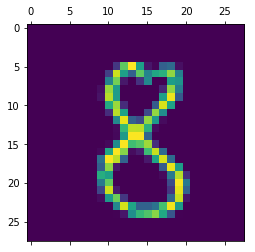

In [4]:
# Showing random example
random=np.random.randint(len(evl_f)-1)
_, ax = plt.subplots()
ax.matshow(evl_f.iloc[random,:].values.reshape(28, 28))
ax.grid(False)

### Convolutional neural network

In [5]:
def my_model(features,labels,mode):
    input_layer= tf.reshape(features, [-1, 28, 28, 1])
    conv1=tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=(5,5),padding="same",activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout, units=10)
    predicted_classes = tf.argmax(logits, 1)  
    
    predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits, name="softmax_tensor"),
            'logits': logits
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op) 
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["class_ids"])
    }   
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [27]:
def train_model(train_f,train_l,evl_f,evl_l,batch_size,steps,parts):
    config=tf.estimator.RunConfig(save_summary_steps=100000,keep_checkpoint_max=5)
    clf=tf.estimator.Estimator(model_fn=my_model,model_dir="C:\Python27\Digit_recognizer\Log4",config=config)
    
    step_new=int(steps/parts)
    for p in range(parts):
        print("part %i" %(p + 1))
        train_input_fn=tf.estimator.inputs.numpy_input_fn(np.array(train_f),\
                                                      np.array(train_l),batch_size=batch_size,num_epochs=1,shuffle=True)
        clf.train(input_fn=train_input_fn,steps=step_new)
    
        evl_input_fn=tf.estimator.inputs.numpy_input_fn(np.array(evl_f,),np.array(evl_l),batch_size=1,shuffle=False)
        clf.evaluate(input_fn=evl_input_fn)
    
    return clf

In [7]:
def generate_images(images, labels, factor):
    image_gen=tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=3, height_shift_range=3,\
                                                              rotation_range=10, zoom_range=0.1)
    images=np.array(images).reshape(-1,1,28,28,1)
    output=[]
    output_l=[]
    for i in range(len(images)):
        gen=image_gen.flow(images[i], [labels[i]])
        for g in range(factor):         
            output.append(next(gen)[0].reshape(784))
            output_l.append(next(gen)[1])
    return pd.DataFrame(np.array(output)).astype(float), pd.Series(np.array(output_l).reshape(-1))

In [9]:
new_f, new_l = generate_images(evl_f.iloc[:5000,:], evl_l.iloc[:5000], 10)

In [11]:
new_f.to_pickle("5000_f_image_gen_3_3_10_0.1.pkl")
new_l.to_pickle("5000_10_l_image_gen_3_3_10_0.1.pkl")

In [13]:
df2=pd.read_pickle("5000_f_image_gen_3_3_10_0.1.pkl")

In [28]:
clf = train_model(new_f, new_l, evl2_f, evl2_l, 30, 3000, 5)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Python27\\Digit_recognizer\\Log4', '_tf_random_seed': None, '_save_summary_steps': 100000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000017A812A4CF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
part 1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Python27\Digit_recognizer\Log4\model.ckpt-4524
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow

KeyboardInterrupt: 

In [132]:
predict_input_fn=tf.estimator.inputs.numpy_input_fn(np.array(test),batch_size=1,shuffle=False)
pred=clf.predict(input_fn=predict_input_fn)
outcome=[]
for i in pred:
    outcome.append(i["class_ids"][0])
outcome=np.array(outcome)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Python27\Digit_recognizer\Log3\model.ckpt-17134
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [133]:
sample=pd.read_csv("sample_submission.csv")
sample["Label"]=outcome
sample.to_csv("Submission2.csv",index=False)